In [1]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from consts import COUNTING_CMAP, HALF_PAGE_FIGSIZE, HISTOGRAM_CMAP
from matplotlib import colors

plt.style.use("mike.mplstyle")

In [2]:
dataset_root = "../datasets/"
genome_dset = datasets.Dataset.load_from_disk(dataset_root + "FLT_genome")
resist_dset = datasets.Dataset.load_from_disk(dataset_root + "PR_resist")
coreceptor_dset = datasets.Dataset.load_from_disk(dataset_root + "V3_coreceptor")
bodysite_dset = datasets.Dataset.load_from_disk(dataset_root + "V3_bodysite")

In [3]:
def make_genome_figure(genome_dset, ax):

    prots = ["GagPol", "Vif", "Vpr", "Tat", "Rev", "Vpu", "Env", "Nef"]

    prot_lens = pd.DataFrame(genome_dset)[prots].applymap(len)
    expected = prot_lens.mode().iloc[0]

    prot_lens["proteome"] = prot_lens.sum(axis=1)

    mdf = pd.melt(
        prot_lens,
        value_vars=prots + ["proteome"],
        value_name="length",
        var_name="protein",
    )
    sns.histplot(
        data=mdf,
        y="protein",
        x="length",
        ax=ax,
        lw=0.1,
        cmap="crest",
        vmin=1,
        vmax=len(prot_lens),
        cbar=True,
        cbar_kws={
            "location": "top",
            "label": "Sequences",
            "ticks": [1, 500, 1000, 1500, len(prot_lens)],
        },
    )
    ax.set_ylabel("")
    ax.set_xlabel("Protein Length")
    sns.despine(ax=ax)

    min_allowed = expected * 0.9

    short = {}
    for col in prots:
        short[col] = prot_lens[col] < min_allowed[col]

    info = {}

    info["premature_stop"] = 100 * pd.DataFrame(short).any(axis=1).mean()
    info["dset_size"] = prot_lens.sum().sum() / 1e6
    info["per_orig"] = 100 * info["dset_size"] / (393)

    return info

In [4]:
def make_resist_figure(resist_dset, ax):
    drugs = ["FPV", "IDV", "NFV", "SQV"]
    drug_data = pd.DataFrame(resist_dset)[drugs]
    drug_data["MultiDrug"] = drug_data.sum(axis=1)
    drug_data.head()

    mdf = pd.melt(
        drug_data.replace({True: 1, False: 0}),
        value_vars=drugs + ["MultiDrug"],
        value_name="value",
        var_name="drug",
    )

    drug_counts = pd.crosstab(mdf["drug"], mdf["value"])
    ax = drug_counts.loc[["MultiDrug"] + drugs].plot(kind="barh", stacked=True, ax=ax)
    ax.legend([], [], frameon=False)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("Sequences")
    ax.set_xticks([0, 500, 1000, len(drug_data)])
    ax.set_xlim(0, len(drug_data))

    info = {
        "any": drug_data.any(axis=1).mean() * 100,
        "all": drug_data.all(axis=1).mean() * 100,
        "obs": len(drug_data),
    }
    return info

In [5]:
def make_coreceptor_figure(coreceptor_dset, ax):
    receptors = ["CXCR4", "CCR5"]
    coreceptor_data = pd.DataFrame(coreceptor_dset)[receptors]
    coreceptor_data["DualTropic"] = coreceptor_data.all(axis=1)

    mdf = pd.melt(
        coreceptor_data,
        value_vars=receptors + ["DualTropic"],
        value_name="value",
        var_name="receptor",
    )

    receptor_counts = pd.crosstab(mdf["receptor"], mdf["value"])
    ax = receptor_counts.loc[["DualTropic"] + receptors].plot(
        kind="barh", stacked=True, ax=ax
    )
    ax.legend([], [], frameon=False)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("Sequences")
    ax.set_xticks([0, 1000, 2000, len(coreceptor_data)])
    ax.set_xlim(0, len(coreceptor_data))

    info = {
        "dual": coreceptor_data["DualTropic"].mean() * 100,
        "r5": coreceptor_data["CCR5"].mean() * 100,
        "x4": coreceptor_data["CXCR4"].mean() * 100,
        "obs": len(coreceptor_data),
    }
    return info

In [6]:
def make_bodysite_figure(bodysite_dset, ax):
    sites = [
        "periphery-tcell",
        "periphery-monocyte",
        "CNS",
        "breast-milk",
        "female-genitals",
        "male-genitals",
        "gastric",
        "lung",
        "organ",
    ]
    bodysite_data = pd.DataFrame(bodysite_dset)[sites]
    bodysite_data["MultiSite"] = bodysite_data.sum(axis=1)

    mdf = pd.melt(
        bodysite_data.replace({True: 1, False: 0}),
        value_vars=sites + ["MultiSite"],
        value_name="value",
        var_name="site",
    )

    bodsite_counts = pd.crosstab(mdf["site"], mdf["value"])
    ax = bodsite_counts.loc[["MultiSite"] + sites[::-1]].plot(
        kind="barh", stacked=True, ax=ax
    )
    ax.legend([], [], frameon=False)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("Sequences")

    ax.set_xticks([0, 2000, 4000, len(bodysite_data)])
    ax.set_xlim(0, len(bodysite_data))

    info = {
        "multi": (bodysite_data["MultiSite"] > 1).mean() * 100,
        "obs": len(bodysite_data),
    }
    return info

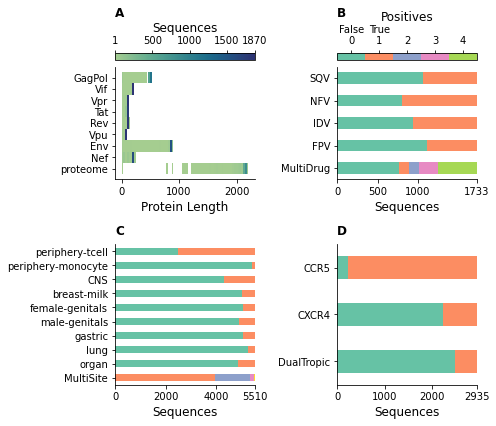

In [7]:
fig, axs = plt.subplots(2, 2, figsize=HALF_PAGE_FIGSIZE)

with sns.color_palette(HISTOGRAM_CMAP):
    genome_info = make_genome_figure(genome_dset, axs[0, 0])
    axs[0, 0].set_title("A", pad=50)

with sns.color_palette(COUNTING_CMAP):

    resist_info = make_resist_figure(resist_dset, axs[0, 1])
    axs[0, 1].set_title("B", pad=50)

    cmap = plt.get_cmap(COUNTING_CMAP)
    norm = colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), 5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=axs[0, 1], ticks=[0, 1, 2, 3, 4], location="top", label="Positives"
    )
    cbar.ax.set_xticklabels(["False\n0", "True\n1", 2, 3, 4])

    body_info = make_bodysite_figure(bodysite_dset, axs[1, 0])
    axs[1, 0].set_title("C", pad=10)
    co_info = make_coreceptor_figure(coreceptor_dset, axs[1, 1])
    axs[1, 1].set_title("D", pad=10)

fig.tight_layout()

In [8]:
try:
    fig.savefig(str(snakemake.output['dataset_description']), dpi=300)
except NameError:
    fig.savefig("Fig2-dataset_description-high.png", dpi=300)

In [9]:
statements = [
    f'{genome_info["premature_stop"]:0.1f}% of genomes contained at least one gene with a premature stop-codon.',
    f'When concatenated, this dataset contains {genome_info["dset_size"]:0.1f} million characters, approximately {genome_info["per_orig"]:0.1f}% of the size of the original training dataset',
    f'Out of the {resist_info["obs"]} Protease sequences with known drug resistance, {resist_info["any"]:0.1f}% of sequences have resistance to at least one drug while {resist_info["all"]:0.1f}% have resistance to all four.',
    f'Figure 2C describes the profile of body-sites where {body_info["obs"]} unique V3 sequences have been isolated with {body_info["multi"]:0.1f}% isolated from multiple locations.',
    f'A partially overlapping set of {co_info["obs"]} V3 sequences contained coreceptor information with the majority being CCR5 binding {co_info["r5"]:0.1f}%, {co_info["x4"]:0.1f}% CXCR4 binding, and {co_info["dual"]:0.1f}% dual tropic.',
]

for s in statements:
    print(s)
    print("")

33.3% of genomes contained at least one gene with a premature stop-codon.

When concatenated, this dataset contains 7.7 million characters, approximately 2.0% of the size of the original training dataset

Out of the 1733 Protease sequences with known drug resistance, 55.8% of sequences have resistance to at least one drug while 28.0% have resistance to all four.

Figure 2C describes the profile of body-sites where 5510 unique V3 sequences have been isolated with 28.3% isolated from multiple locations.

A partially overlapping set of 2935 V3 sequences contained coreceptor information with the majority being CCR5 binding 92.1%, 23.9% CXCR4 binding, and 16.0% dual tropic.

